In [1]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 


%matplotlib inline

In [2]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    return df


In [35]:
'''def callstime(df, col_arrive):
    yearmonthday = df[col_arrive].astype(str).str.split(" ")
    df["year"] = yearmonthday.apply(lambda x: x[2])
    df["day"] = yearmonthday.apply(lambda x: x[1])
    month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec":12}
    df["month"] = yearmonthday.apply(lambda x: month_dict[x[0]])
    df["time"] = yearmonthday.apply(lambda x: x[3])
    return df'''
    
    

In [27]:
'''#don't need to run again - all are associated to establish SQL table
calls = pd.read_csv("data/Call_Data.csv")
calls = callstime(calls,"Arrived Time")
calls17 = calls[calls["year"].isin(["2014", "2015", "2016", "2017", "2018", "2019"])]
calls17["epoch_calls"] = epoch_second2'''

'''# remove repetitive columns

calls_tosql = calls17.drop(columns =["year","day", "month", "time", "Precinct", "Sector", "Arrived Time"])
calls_tosql.set_index("epoch_calls", inplace=True)
'''

# move calls to sqlite table - DONT REPEAT
# calls_tosql.to_sql("log", con=cnx, index=True)
'''
# calculate and add column for epoch time
bar = pd.to_datetime( calls17["Arrived Time"], format="%b %d %Y %I:%M:%S:%f%p" )
epoch_second2 = bar.map(lambda x: x.value/1e9)'''


In [24]:
'''# iterate through the dataframe calls17 and remove repeated CAD numbers

_row = []
#val_lst = []
for ix, row in calls17.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    CAD = row["CAD Event Number"]
    EC = row['Event Clearance Description']
    if (CAD in two) and (EC == '-'):
        _row.append(ix)
_row''''''

'# iterate through the dataframe calls17 and remove repeated CAD numbers\n\n_row = []\n#val_lst = []\nfor ix, row in calls17.iterrows():\n    # query the 911 calls database\n    # for each call, append to a bunch of records that we\'re building up into a dataframe\n    CAD = row["CAD Event Number"]\n    EC = row[\'Event Clearance Description\']\n    if (CAD in two) and (EC == \'-\'):\n        _row.append(ix)\n_row'

In [3]:
force = pd.read_csv("data/Use_Of_Force.csv")


In [4]:
# change to epoch time
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)

force["epoch"] = epoch_second


In [6]:
# remove repetitive columns (incident type, officer id and subject id are in ID respectively)

force = force.drop(columns=["Occured_date_time", "ID"])


In [7]:
# create engine
cnx = sqlite3.connect('/Users/sarahburgart/galvanize/week7/capstone2/calls.sqlite')

In [8]:
# create cursor
cur = cnx.cursor()


In [ ]:
# iterate through the dataframe 'force', make a bunch of new rows, and then make a dataframe out of those

new_row = []
#val_lst = []
for ix, row in force.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    value = row.epoch
    rowbeat = row.Beat
    vals = cur.execute(f"select * from log where epoch_calls BETWEEN ({value} - 300) AND {value} ").fetchall()
    #val_lst.extend([value, val[0]])
    cnx.commit()
    
    for val in vals:
        new_row.extend( [[ix,  val[0], row.epoch, row.Incident_Num, row.Officer_ID, row.Subject_ID, val[1], val[2],
                        row.Incident_Type, row.Precinct, 
                        row.Sector, row.Beat, val[8], val[4],
                        row.Subject_Race, row.Subject_Gender, val[3], val[5], val[6], 
                        val[7], row.year, row.month, row.day, row.time] ])
  

In [ ]:
# look at force - are beat and officer correlated?
#force.info()
#force.groupby("Officer_ID")[["Beat"]].sum()

# officer may be at more than one beat

In [50]:
merged = pd.DataFrame(new_row, columns=["index","call_epoch", "force_epoch", "Incident_Num", "Officer_ID",
                                        "Subject_ID", "CAD_Event_Number", "Event_Clearance_Description",
                                "Force_Level", "Precinct", 
                                "Sector", "force_beat", "calls_beat", "Priority",
                                "Subject_Race", "Subject_Gender","Call_Type", "Initial_Call_Type", "Final_Call_Type",
                                "Original_Time_Queued", "year", "month","day", "time " ])



In [51]:
merged.call_epoch = pd.to_numeric(merged.call_epoch, downcast="integer")
merged.force_epoch = pd.to_numeric(merged.force_epoch, downcast="integer")

In [ ]:
dfrs = merged["CAD_Event_Number"].value_counts()
two = []
for v, i in zip(dfrs.values, dfrs.index):
    if v >1:
        two.append(i)
# len(two) == 362  
s = [x > 1 for x in dfrs]
dd =dfrs[s]

t = merged[merged["CAD_Event_Number"].isin(two)]
indicest = t[t["Event_Clearance_Description"] == "-"].index
indicest

merged.drop(indicest, axis=0, inplace=True)

In [52]:
# make numeric
rev_df = merged.replace("-1", -1)
rev_df["time"] = pd.to_datetime(rev_df["time "])
rev_df["Original_Time_Queued"] = pd.to_datetime(rev_df["Original_Time_Queued"])
rev_df["time"].apply(lambda x: pd.datetime.strftime(x, '%H:%M:%S'))

rev_df.head()


,index,call_epoch,force_epoch,Incident_Num,Officer_ID,Subject_ID,CAD_Event_Number,Event_Clearance_Description,Force_Level,Precinct,...,Subject_Gender,Call_Type,Initial_Call_Type,Final_Call_Type,Original_Time_Queued,year,month,day,time,time
0,0,1511832912,1511833200,18412,2238,14470,2017000438600,ASSISTANCE RENDERED,Level 1 - Use of Force,-,...,Female,ONVIEW,"PREMISE CHECK, OFFICER INITIATED ONVIEW ONLY",--PREMISE CHECKS - CRIME PREVENTION,2017-11-28 01:35:12,2017,11,28,01:40:00AM,2019-07-03 01:40:00
1,0,1511832919,1511833200,18412,2238,14470,2017000438595,ASSISTANCE RENDERED,Level 1 - Use of Force,-,...,Female,911,EXPLOSION - IP/JO,--DISTURBANCE - NOISE,2017-11-28 01:26:30,2017,11,28,01:40:00AM,2019-07-03 01:40:00
2,0,1511833107,1511833200,18412,2238,14470,2017000438597,REPORT WRITTEN (NO ARREST),Level 1 - Use of Force,-,...,Female,"TELEPHONE OTHER, NOT 911","SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,2017-11-28 01:27:55,2017,11,28,01:40:00AM,2019-07-03 01:40:00
3,1,1498104779,1498104900,16162,1589,12833,2017000224279,NO POLICE ACTION POSSIBLE OR NECESSARY,Level 1 - Use of Force,-,...,Male,911,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,2017-06-22 03:11:26,2017,06,22,04:15:00AM,2019-07-03 04:15:00
4,2,1532199428,1532199480,30638,2146,17272,2018000269265,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,Level 1 - Use of Force,-,...,Male,911,TRAFFIC - BLOCKING ROADWAY,--TRAFFIC - BLOCKING TRAFFIC,2018-07-21 17:38:10,2018,07,21,06:58:00PM,2019-07-03 18:58:00


In [54]:
# make second df and keep leaky data for exploration later
# take out event description and final call (bc you wouldn't know)
rev_df_leaky = rev_df.copy(deep=True)
type(rev_df_leaky)

pandas.core.frame.DataFrame

In [55]:
rev_df = pd.get_dummies(data = rev_df, 
                     columns=["force_beat","Force_Level", "calls_beat", 
                              "Subject_Gender", "Call_Type","Subject_Race", "Initial_Call_Type", 
                             "Precinct", "Sector", "Officer_ID", "Subject_ID"], 
                     prefix=["forceb", "forcelevel", "callsb",  
                             "Gender", "CallType", "Race", "InitCall", 
                            "Precinct","Sector", "OID", "SID" ])



# pd.get_dummies(data=df, columns=['A', 'B'])
                      

In [56]:

rev_df["year"] = rev_df["year"].astype(int)
rev_df["month"] = rev_df["month"].astype(int)
rev_df["day"] = rev_df["day"].astype(int)
rev_df["day_of_week"] = rev_df.Original_Time_Queued.dt.dayofweek


In [60]:
# drop leaky data
rev_df.drop(["Event_Clearance_Description","Final_Call_Type", "time "], axis=1, inplace=True )

In [36]:
'''# exploring unsupervised learning

# make appropriate array to use SVD
svdf = rev_df.drop(["time", "Original_Time_Queued"], axis=1)
sdf = svdf.iloc[:10000, :]'''

'# exploring unsupervised learning\n\n# make appropriate array to use SVD\nsvdf = rev_df.drop(["time", "Original_Time_Queued"], axis=1)\nsdf = svdf.iloc[:10000, :]'

In [37]:
'''u, s, vh = np.linalg.svd(sdf)'''
'''power = s*2
total_power = sum(power)
total_power'''
'''vh.shape, s.shape, u.shape, svdf.shape'''
'''svV  = pd.DataFrame(vh[:10])
svV.columns = svdf.columns
svV'''
'''sv0 = svV.iloc[0,:]
sv0 = abs(sv0)
np.argmax(sv0)
sv0[6] # equals CAD_Event_Number
#svV.iloc[0,:]'''



'sv0 = svV.iloc[0,:]\nsv0 = abs(sv0)\nnp.argmax(sv0)\nsv0[6] # equals CAD_Event_Number\n#svV.iloc[0,:]'

In [21]:
# dataframe rev_df before dropping CAD dupes
rev_df_orig = rev_df.copy(deep=True)

In [22]:

dfrs = rev_df["CAD_Event_Number"].value_counts()
two = []
for v, i in zip(dfrs.values, dfrs.index):
    if v >1:
        two.append(i)
# len(two) == 362  
s = [x > 1 for x in dfrs]
dd =dfrs[s]

ts = rev_df[rev_df["CAD_Event_Number"].isin(two)]
indices = ts[ts["ECD_-"] == 1].index
indices

rev_df.drop(indices, axis=0, inplace=True)

In [23]:
#rev_df.drop(indicest, axis=0, inplace=True)

len(rev_df_orig), len(rev_df), len(merged)

(27038, 27007, 27007)

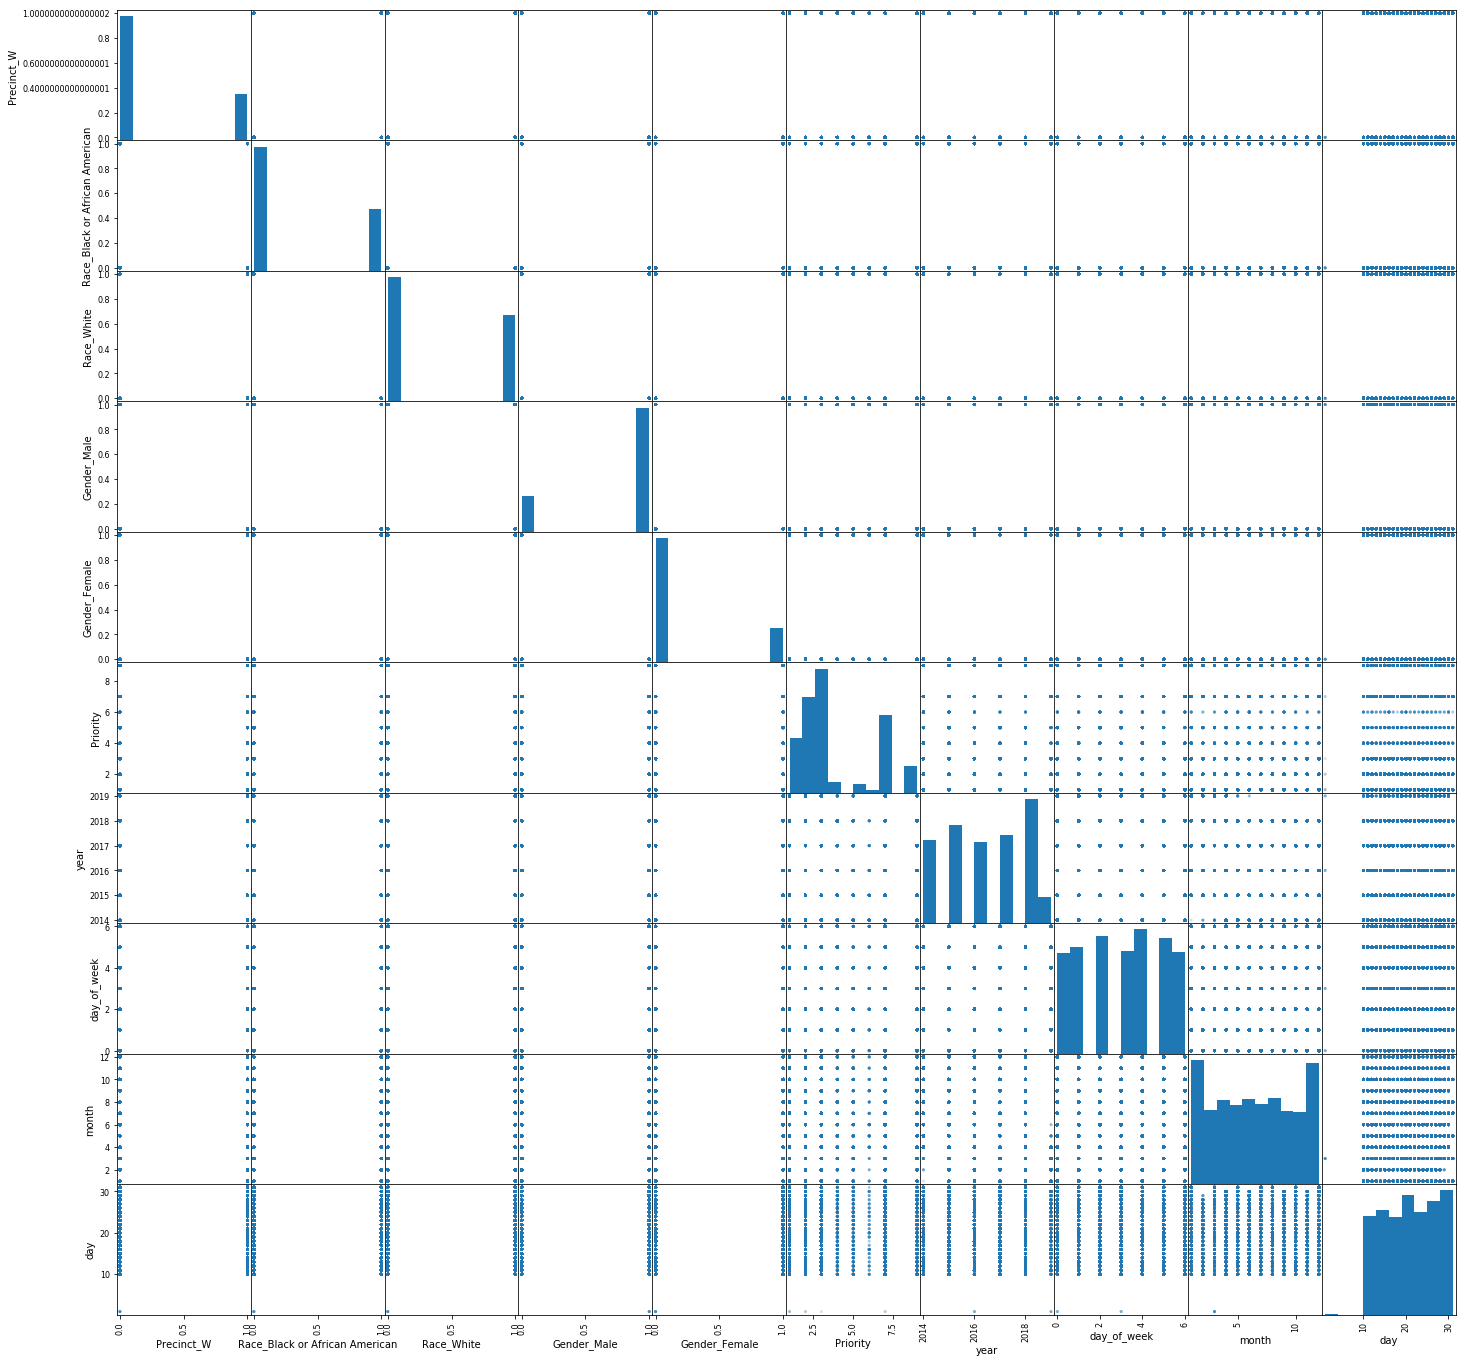

In [27]:
# make smaller df for scatter_matrix
sm = rev_df[['Precinct_W', 'Race_Black or African American', 'Race_White',
       'Gender_Male', 'Gender_Female', 'Priority', 'year', 'day_of_week',
       'month', 'day']]

pd.plotting.scatter_matrix(sm, alpha=0.2, figsize=(24,24));

In [28]:
'''gee = rev_df[rev_df["CAD_Event_Number"] == 2014000114743]
#gee.info(verbose=True)
wha = force[force["epoch"] == 1397519220]
wha'''

'gee = rev_df[rev_df["CAD_Event_Number"] == 2014000114743]\n#gee.info(verbose=True)\nwha = force[force["epoch"] == 1397519220]\nwha'

In [29]:
calls17[calls17["CAD Event Number"] == 2014000119510][["Beat"]]

,Beat
1851960,C1


In [30]:
event_lst = ["CITATION ISSUED (CRIMINAL OR NON-CRIMINAL) ",
"PHYSICAL ARREST MADE",
"OTHER REPORT MADE" ,
"FOLLOW-UP REPORT MADE",
"PROBLEM SOLVING PROJECT" ,
"STREET CHECK WRITTEN ",
"INCIDENT LOCATED, PUBLIC ORDER RESTORED ",
"TRANSPORTATION OR ESCORT PROVIDED", 
"-",
"SERVICE OF DVPA ORDER",
"RADIO BROADCAST AND CLEAR",
"NON-CRIMINAL REFERRAL",
"EXTRA UNIT" ,
"(NOT CURRENTLY USED) ALARM NO RESPONSE" ] 

In [31]:
rev_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27007 entries, 0 to 27037
Data columns (total 5652 columns):
index                                                          int64
call_epoch                                                     int64
force_epoch                                                    int64
Incident_Num                                                   int64
CAD_Event_Number                                               int64
Priority                                                       int64
Original_Time_Queued                                           datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
time                                                           object
time                                                           datetime64[ns]
forceb_-                                  

In [28]:
clf = RandomForestClassifier(n_estimators=100, random_state=659, oob_score=True)



In [29]:
rev = rev_df.drop(["index", "call_epoch", "force_epoch", "Incident_Num", "CAD_Event_Number", "Original_Time_Queued",
                "forcelevel_Level 1 - Use of Force", "forcelevel_Level 2 - Use of Force", "forcelevel_Level 3 - OIS",
                "forcelevel_Level 3 - Use of Force", "time ","time"], axis=1)
cols = rev.columns

In [ ]:
type(rev)

In [30]:
# X for classifier
X = rev_df.drop(["index", "call_epoch", "force_epoch", "Incident_Num", "CAD_Event_Number", "Original_Time_Queued",
                "forcelevel_Level 1 - Use of Force", "forcelevel_Level 2 - Use of Force", "forcelevel_Level 3 - OIS",
                "forcelevel_Level 3 - Use of Force", "time ","time"], axis=1)

#X.info(verbose=True)

In [31]:
X_scaled = StandardScaler().fit_transform(X)

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
y = merged.Force_Level
y.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 })
y.shape, X_scaled.shape

((27007,), (27007, 5640))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=659)


In [34]:
clf.fit(X_train, y_train )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=659, verbose=0, warm_start=False)

In [35]:
len(clf.feature_importances_), len(cols)

(5640, 5640)

In [36]:
# most important features
indices = np.argsort(clf.feature_importances_)
big = indices[-10:]

cols[big]

Index(['Precinct_W', 'Race_Black or African American', 'Race_White',
       'Gender_Male', 'Gender_Female', 'Priority', 'year', 'day_of_week',
       'month', 'day'],
      dtype='object')

In [37]:
# least important features
little = indices[:20]
cols[little]


Index(['SID_11415', 'FinCall_SERVICE - WELFARE CHECK', 'SID_12213',
       'SID_12211', 'FinCall_SICK PERSON', 'SID_6391', 'SID_6480', 'SID_12111',
       'FinCall_SUICIDE, SUICIDAL PERSON AND ATTEMPTS', 'SID_6580',
       'FinCall_SUSPICIOUS PACKAGE', 'SID_12109',
       'FinCall_ROBBERY - IP/JO (INCLUDES STRONG ARM)',
       'FinCall_TRAFFIC - BO SIGNALS AND DOWN SIGNS', 'SID_6598', 'SID_17731',
       'FinCall_TRU - THEFT', 'SID_6608', 'InitCall_-ASSIGNED DUTY - STAKEOUT',
       'SID_6941'],
      dtype='object')

In [38]:
clf.oob_score_ # accuracy of training set

0.9562138393890303

In [63]:
yhat = clf.predict(X_test)

In [64]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

0.9555720103665309

In [39]:
pp = clf.predict_proba(X_test)

In [40]:
pp

array([[0.93, 0.06, 0.01, 0.  ],
       [0.71, 0.28, 0.01, 0.  ],
       [0.95, 0.03, 0.02, 0.  ],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.98, 0.02, 0.  , 0.  ],
       [0.36, 0.61, 0.  , 0.03]])

In [41]:
# need to do gradient boosting to do partial dependency plotting
gdbr = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                  max_depth=1, random_state=0).fit(X, y)


In [42]:
#gdbr.feature_importances_

indices_gdbr = np.argsort(gdbr.feature_importances_)
big_gdbr = indices[-10:]

cols[big_gdbr]


Index(['Precinct_W', 'Race_Black or African American', 'Race_White',
       'Gender_Male', 'Gender_Female', 'Priority', 'year', 'day_of_week',
       'month', 'day'],
      dtype='object')

In [46]:
list(big_gdbr)

[650, 163, 167, 154, 153, 0, 1, 5639, 2, 3]

In [29]:

# make plots
my_plots = plot_partial_dependence(gdbr,       
                                   features=[163, 153], # column numbers of plots to show
                                   X=X,            # raw predictors data.
                                   #feature_names=['day', 'month', 'day_of_week'],
                                   label=["Level 1 - Use of Force"],# for multi-class must use label
                                   grid_resolution=10)

NameError: name 'gdbr' is not defined

In [57]:
#gdbr.predict(X_test) 
#gdbr.predict_proba(X_test)
gdbr.score(X_test, y_test)

0.8805997778600518

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:

importance = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

r = range(importance.shape[0])
f = clf.feature_importances_
yerr = importance

# Extend the code to find the standard deviation of the importance for each feature across all trees. 
fig, ax = plt.subplots(1,1, figsize=(20,8), sharex=True)
#axs.flatten()

ax.errorbar(r,f, yerr=yerr)
ax.set_title('all errorbars')


#fig.suptitle('Errors')

plt.tight_layout()
plt.xticks(np.arange(len(r)), X.columns, rotation="vertical")
plt.show();
#plt.bar(r, f, yerr=yerr, align="center");




In [ ]:
'''force3.Incident_Num.value_counts()
t = force3[force3["Incident_Num"] == 12308]
#t.drop_duplicates("CAD_Event_Number", inplace=True) # 'force_beat', 'calls_beat'
len(t.CAD_Event_Number.value_counts()), len(t)
t2 = t[t.force_beat.values == t.calls_beat.values]
t2'''

'''force3 = merged[merged.Force_Level == "Level 3 - Use of Force"]
force2 = merged[merged.Force_Level == "Level 2 - Use of Force"]
force1 = merged[merged.Force_Level == "Level 1 - Use of Force"]
len(force3), len(force2), len(force1), len(merged)'''

'''# group by incident number first

x = force3.Subject_Race.value_counts()
lst = list(x.values)
plt.bar(np.arange(7), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1, 2, 3,4,5,6), ('White', 'Black or African American ', 'Not Specified ','Hispanic or Latino',
                               'Asian','American Indian/Alaska Native ','Nat Hawaiian/Oth Pac Islander'), 
          rotation='vertical')
plt.title("Level 3 Force by Race 2014-2019");'''

In [ ]:
'''force3beats = force3[force3.force_beat.values == force3.calls_beat.values]
len(force3beats)
f3b = force3beats.drop(["index", "Force_Level", "Precinct"], axis=1)
f3b.drop("Sector", axis=1, inplace=True)
#f3b '''

In [ ]:
'''#rev_df.drop(["Subject_Gender", "Subject_Race"], axis=1, inplace=True)
rev_df.info(verbose=True)'''

In [ ]:
'''y = force3.Subject_Gender.value_counts()
lst = list(y.values)
plt.bar(np.arange(2), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1), ('Male', 'Female'), 
          rotation='horizontal')
plt.title("Level 3 Force by Gender 2014-2019");'''

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(20,12))
fct = force3.Final_Call_Type.value_counts()
lst = list(fct.values)
plt.bar(np.arange(99), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks(np.arange(99), lst,  rotation='vertical')
plt.title("Level 3 Force by Final Call Type 2014-2019");